In [1]:
import yfinance as yf
import pandas as pd

# Download historical data for Nifty 100
ticker = "^NSEI"  # Nifty 50 index; Nifty 100 is not directly available, so use Nifty 50 as a proxy
data = yf.download(ticker, start='2020-01-01', end='2024-01-01')

# Prepare the data
data['Returns'] = data['Adj Close'].pct_change()
data = data.dropna()

# Save the data if needed
data.to_csv('nifty100_data.csv')

[*********************100%%**********************]  1 of 1 completed


In [2]:
import statsmodels.api as sm

# Fit ARIMA model
returns = data['Returns']
model = sm.tsa.ARIMA(returns, order=(5, 1, 0))  # Adjust the order as needed
results = model.fit()

# Forecast
forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
forecast_conf_int = forecast.conf_int()

# Get forecasted returns
forecasted_returns = forecast.predicted_mean


c:\Users\aditi\miniconda3\envs\project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\project\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

In [16]:
import gym
from gym import spaces
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, data):
        super(TradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.action_space = spaces.Discrete(3)  # Buy, Hold, Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self.current_step += 1
        if self.current_step >= len(self.data):
            done = True
        else:
            done = False

        reward = self.data.iloc[self.current_step]['Returns'] * (action - 1)  # Simplistic reward
        obs = self.data.iloc[self.current_step].values

        return obs, reward, done, {}

    def render(self, mode='human'):
        pass

# Initialize environment
env = TradingEnv(data[['Returns']])

# Create RL model
from stable_baselines3 import PPO
model = PPO('MlpPolicy', env, verbose=1)
# model.learn(total_timesteps=10000)

# Evaluate model
obs = env.reset()
actions = []
for _ in range(len(data) - 1):
    action, _states = model.predict(obs)
    actions.append(action)
    obs, _, done, _ = env.step(action)
    if done:
        obs = env.reset()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\aditi\miniconda3\envs\project\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Sharpe Ratio (RL): 1.263050731246531
Sharpe Ratio (ARIMA): 0.05548306047507281
Maximum Drawdown (RL): 0.0
Maximum Drawdown (ARIMA): 26.429671493519795


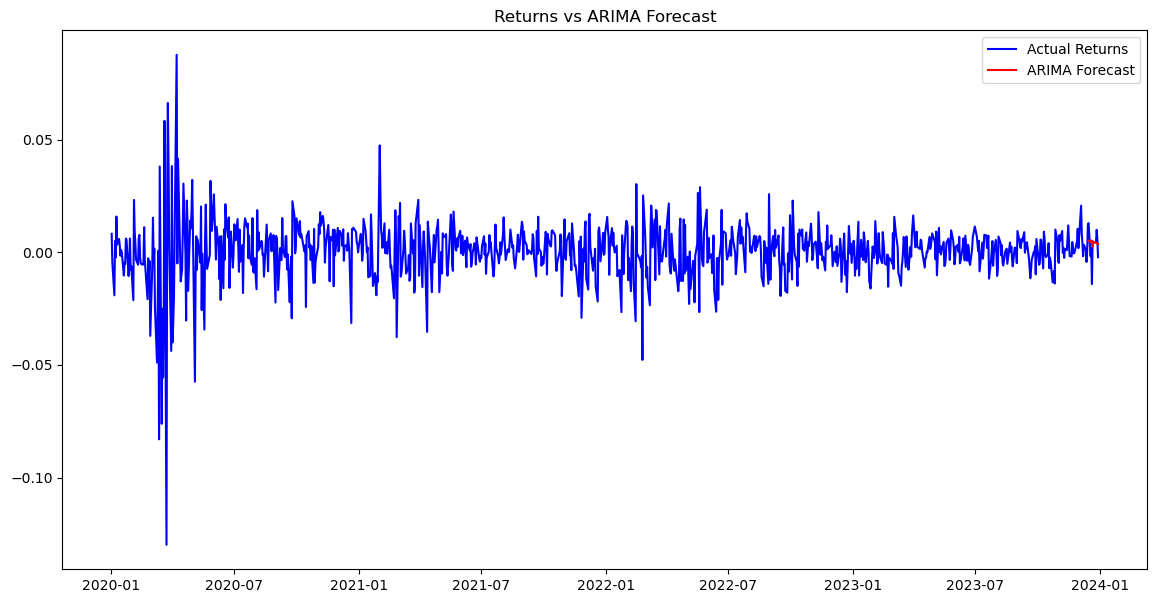

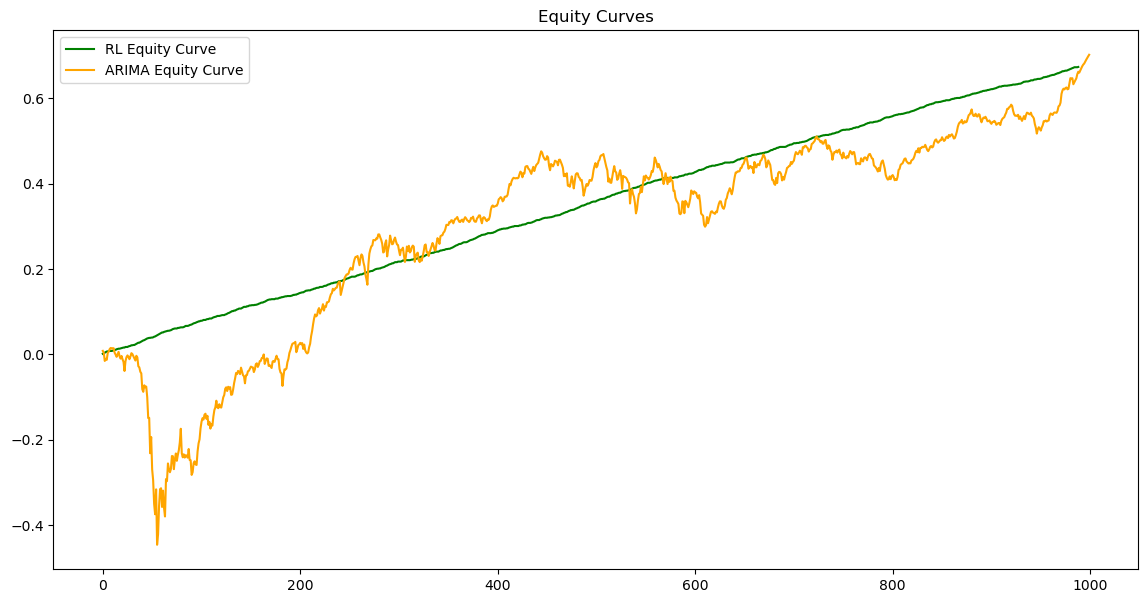

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert actions to returns (for simplicity, assuming 'actions' are trading signals)
# Replace this with the actual logic to calculate returns from actions
returns_rl = np.array(actions) * data['Returns'].mean()  # Simplistic; adjust as needed
returns_arima = np.concatenate([data['Returns'].values, forecasted_returns])

# Calculate Sharpe Ratio
sharpe_rl = np.mean(returns_rl) / np.std(returns_rl) if np.std(returns_rl) != 0 else 0
sharpe_arima = np.mean(returns_arima) / np.std(returns_arima) if np.std(returns_arima) != 0 else 0

print(f"Sharpe Ratio (RL): {sharpe_rl}")
print(f"Sharpe Ratio (ARIMA): {sharpe_arima}")

# Calculate Maximum Drawdown
def max_drawdown(returns):
    cum_returns = np.cumprod(1 + returns) - 1
    peak = np.maximum.accumulate(cum_returns)
    drawdowns = (peak - cum_returns) / (peak + 1e-10)
    return np.max(drawdowns)

max_dd_rl = max_drawdown(returns_rl)
max_dd_arima = max_drawdown(returns_arima)

print(f"Maximum Drawdown (RL): {max_dd_rl}")
print(f"Maximum Drawdown (ARIMA): {max_dd_arima}")

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Returns'], label='Actual Returns', color='blue')
plt.plot(data.index[-forecast_steps:], forecasted_returns, label='ARIMA Forecast', color='red')
plt.title('Returns vs ARIMA Forecast')
plt.legend()
plt.show()

# Plot equity curves
plt.figure(figsize=(14, 7))
plt.plot(np.cumsum(returns_rl), label='RL Equity Curve', color='green')
plt.plot(np.cumsum(returns_arima), label='ARIMA Equity Curve', color='orange')
plt.title('Equity Curves')
plt.legend()
plt.show()
